In [1]:
import os
import torch
from torchtools.utils import plot_batch

from train_autoprotonet import get_dataset, get_model
from vis_prototypes import get_prototypes, get_support_query_data_labels_model, generate_prototype_img_using_adam, \
                           generate_prototype_img_using_adam_xent
from utils import count_accuracy

In [18]:
ckpt_dir = '/vulcanscratch/psando/checkpoints-meta/workshop_paper_checkpoints/mi-autoprotonet-5w5s'

test_way = 5
val_shot = 20
val_query = 5
val_episode = 2000
episodes_per_batch = 1

class Options(object):
    def __init__(self, dataset, network, test_way, val_shot, val_query, head='ProtoNet'):
        self.dataset = dataset
        self.network = network
        self.head = head
        self.activation = 'LeakyReLU'
        self.test_way = test_way
        self.val_shot = val_shot
        self.val_query = val_query
        self.episodes_per_batch = episodes_per_batch
opt = Options(dataset=('CIFAR_FS' if 'cifarfs' in ckpt_dir else 'miniImageNet'), network=('AutoProtoNet' if 'autoprotonet' in ckpt_dir else 'ProtoNet'), test_way=test_way, val_shot=val_shot, val_query=val_query)

In [19]:
data_support, labels_support, data_query, labels_query, embedding_net, cls_head = get_support_query_data_labels_model(opt, epoch=41)

Loading mini ImageNet dataset - phase train
Loading mini ImageNet dataset - phase val


In [20]:
labels_support = labels_support.squeeze()
sort_support_indices = torch.argsort(labels_support)

# plot_batch(data_support[sort_support_indices].cpu(), figsize=(20,20), nrow=val_shot)

In [21]:
DATA_SHAPE = (32 if opt.dataset == 'CIFAR_FS' else 84)
GRAIN = (1 if opt.dataset == 'CIFAR_FS' else 4)
def downsample(x, step=GRAIN):
    down = torch.zeros([len(x), 3, DATA_SHAPE//step, DATA_SHAPE//step])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=GRAIN):
    up = torch.zeros([len(x), 3, DATA_SHAPE, DATA_SHAPE])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

from torch.distributions.multivariate_normal import MultivariateNormal

conditionals = []
for i in range(test_way):
    imc = data_support[labels_support == i]
    down_flat = downsample(imc).view(len(imc), -1)
    mean = down_flat.mean(dim=0)
    down_flat = down_flat - mean.unsqueeze(dim=0)
    cov = down_flat.t() @ down_flat / len(imc)
    dist = MultivariateNormal(mean, covariance_matrix=cov+1e-4*torch.eye(3 * DATA_SHAPE//GRAIN * DATA_SHAPE//GRAIN))
    conditionals.append(dist)

In [22]:
img_seed = torch.stack([conditionals[i].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                     for i in range(test_way)])
img_seed = torch.clamp(img_seed, min=0, max=1)
img_seed = upsample(img_seed)
print(img_seed.shape)
# plot_batch(img_seed, figsize=(15,15))

torch.Size([5, 3, 84, 84])


In [23]:
ckpt = torch.load(os.path.join(ckpt_dir, 'best_model.pth'))
cls_head.load_state_dict(ckpt['head'], strict=True)
embedding_net.load_state_dict(ckpt['embedding'], strict=True)

<All keys matched successfully>

In [24]:
with torch.no_grad():
    emb_query = embedding_net(data_query)
    emb_support = embedding_net(data_support)
    print('emb query shape', emb_query.shape)
    print('emb support shape', emb_support.shape)
    train_n_support = test_way * val_shot
    train_n_query = test_way * val_query
    emb_query = emb_query.reshape(episodes_per_batch, train_n_query, -1)
    emb_support = emb_support.reshape(episodes_per_batch, train_n_support, -1)
    print('emb query shape reshaped', emb_query.shape)
    print('emb support shape reshaped', emb_support.shape)
    prototypes = get_prototypes(emb_query, emb_support, labels_support, test_way, val_shot)
    print('prototypes shape', prototypes.shape)

emb query shape torch.Size([25, 1600])
emb support shape torch.Size([100, 1600])
emb query shape reshaped torch.Size([1, 25, 1600])
emb support shape reshaped torch.Size([1, 100, 1600])
prototypes shape torch.Size([1, 5, 1600])


In [25]:
# proto_imgs_adam = generate_prototype_img_using_adam(embedding_net, prototypes.squeeze(dim=0), img_size=(32 if opt.dataset == 'CIFAR_FS' else 84), 
#                                                     lr=0.01,
#                                                     max_steps=10000,
#                                                     use_tv=True,
#                                                     start_from=None)
# proto_imgs_adam = generate_prototype_img_using_adam_xent(embedding_net, cls_head, emb_support, labels_support, img_size=(32 if opt.dataset == 'CIFAR_FS' else 84), 
#                                        lr=0.01, way=test_way, shot=val_shot,
#                                        max_steps=2000, rand_init=False, use_tv=False, start_from=img_seed)

In [26]:
# plot_batch(proto_imgs_adam.cpu(), figsize=(20,20))

In [27]:
# Plot decoder reconstructions of adam optimized images
# proto_imgs_decoder = embedding_net.forward_plus_decoder(img_seed.cuda())
# plot_batch(proto_imgs_decoder.cpu(), figsize=(20,20))

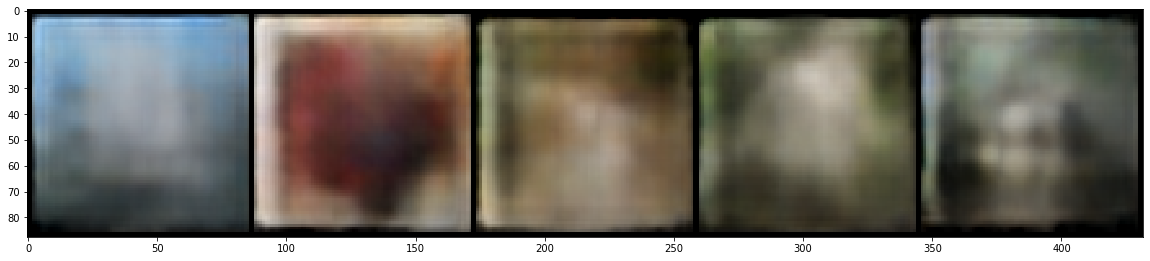

In [28]:
# Plot decoder reconstructions of prototypes
plot_batch(embedding_net.forward_decoder(prototypes.reshape(embedding_net.embedding_shape)).cpu(), figsize=(20,20))

In [29]:
# Plot decoder reconstructions of support data
# plot_batch(embedding_net.forward_decoder(emb_support.reshape(embedding_net.embedding_shape))[sort_support_indices].cpu(), figsize=(20,20), nrow=val_shot)

Predictions: tensor([4, 0, 0, 4, 0, 1, 1, 4, 1, 1, 4, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 0, 0,
        4], device='cuda:0')
Labels     : tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4], device='cuda:0')
Accuracy   : 72.00%


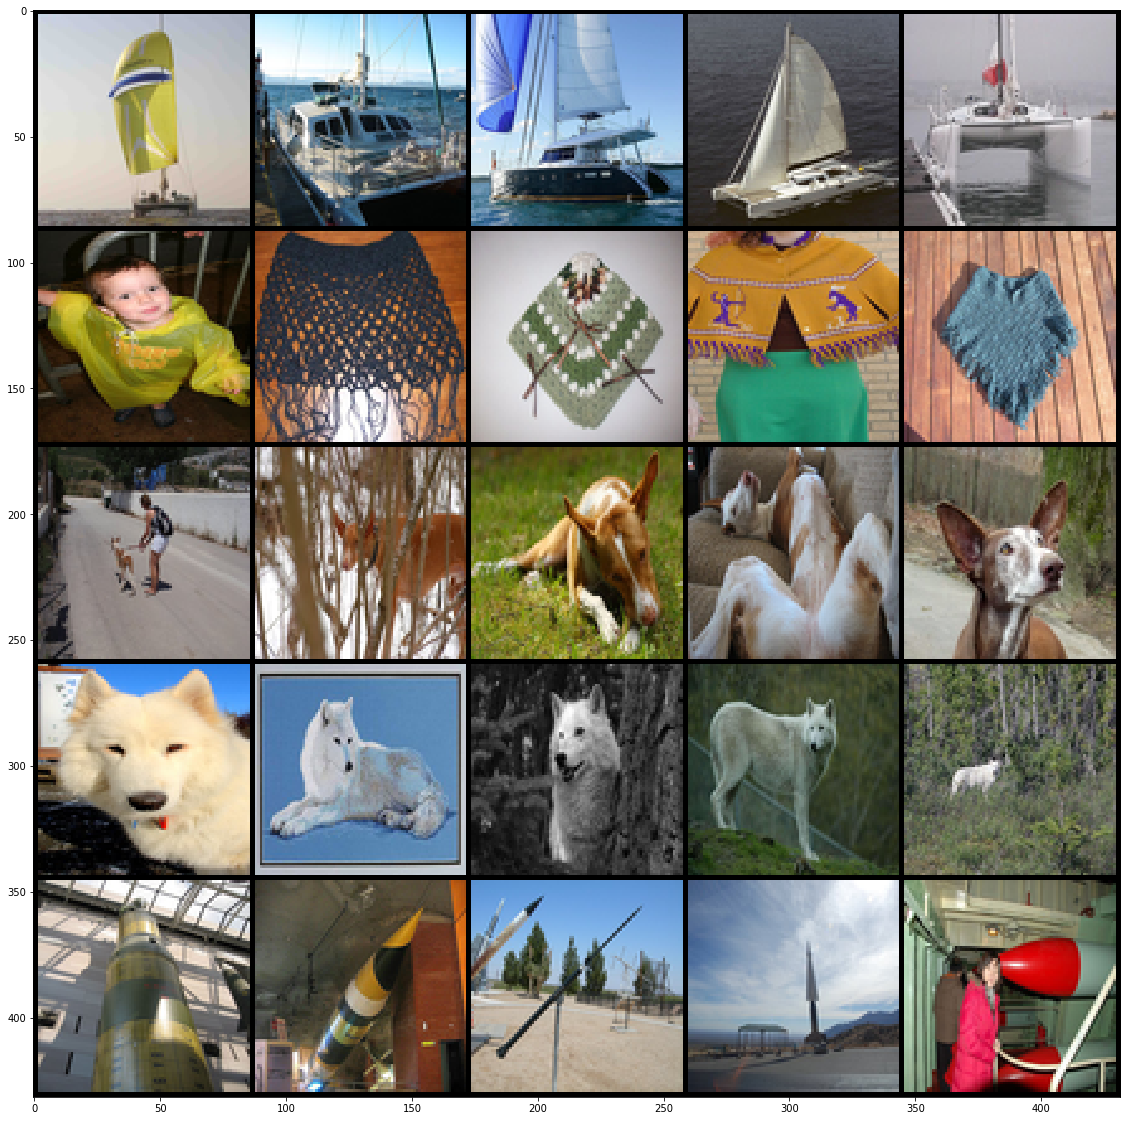

In [30]:
# Sort query data
labels_query = labels_query.squeeze()
sort_query_indices = torch.argsort(labels_query)

# Produce logits
logits = cls_head(emb_query.squeeze(dim=0)[sort_query_indices].unsqueeze(dim=0), emb_support, labels_support, test_way, val_shot)
pred = torch.argmax(logits.reshape(-1, test_way), dim=1).view(-1)
sorted_labels_query = labels_query[sort_query_indices].reshape(-1)
acc = count_accuracy(logits.reshape(-1, test_way), sorted_labels_query.reshape(-1))
print('Predictions:', pred)
print('Labels     :', sorted_labels_query)
print('Accuracy   : {:.2f}%'.format(acc.item()))

# Plot query data
plot_batch(data_query[sort_query_indices].cpu(), figsize=(20,20), nrow=val_query)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


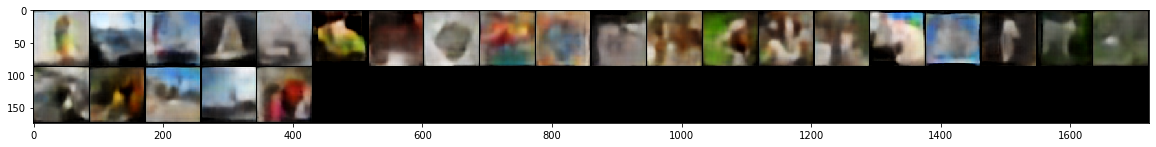

In [31]:
# Plot decoder reconstructions of query data
plot_batch(embedding_net.forward_decoder(emb_query.reshape(embedding_net.embedding_shape))[sort_query_indices].cpu(), figsize=(20,20), nrow=val_shot)